# Import modules

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
random_state=59

In [17]:
df=pd.read_pickle('data/arbres_grenoble_clean.pkl')

# Data selection

## Removing missing years

In [18]:
#I delete the row where we don't a year for the planting
df_missing_year=df.dropna(axis=0, subset=['annee_de_plantation'])
df.dropna(axis=0, subset=['annee_de_plantation'], inplace=True)
df['annee_de_plantation'].astype(int)


elem_point_id
34835    2015
34836    2015
34837    2015
34838    2015
34839    2015
         ... 
44732    2018
44733    2018
44734    2018
44741    2018
44742    2018
Name: annee_de_plantation, Length: 29526, dtype: int64

# Remove sector more than 6 

In [19]:
df=df[df['adr_secteur']<7]

# Map

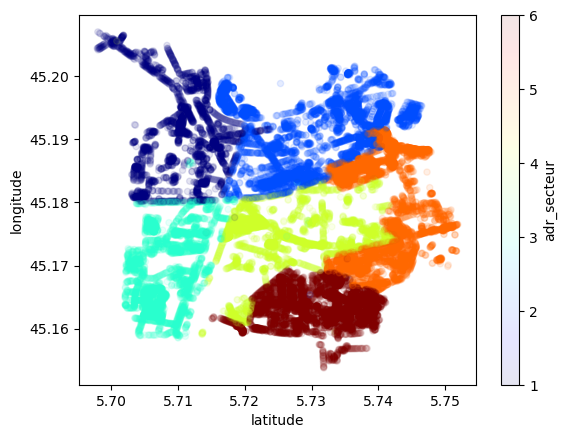

In [20]:
df.plot(
    kind='scatter',
    x='latitude',
    y='longitude',
    alpha=0.1,
    c='adr_secteur',
    cmap=plt.get_cmap("jet"),
    colorbar=True
)
plt.show()


# Train-test split

In [21]:
from sklearn.model_selection import train_test_split

X=df.drop("annee_de_plantation", axis=1)
y=df["annee_de_plantation"]


X_train, X_test, y_train, y_test= train_test_split(X, y, random_state=random_state)

# Function

In [22]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score

def show_results(model, X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test, graph=True):

    """
    Show two graph to compare the performance of a model
    between train data and test data
    """
    fig,(ax1, ax2)=plt.subplots(1,2,figsize=(10,5), sharey=True)

    y_test_pred = model.predict(X_test)
    y_train_pred=model.predict(X_train)
    error_test=abs(y_test_pred-y_test)
    
    rmse_test=root_mean_squared_error(y_test, y_test_pred)
    rmse_train=root_mean_squared_error(y_train, y_train_pred)
    print(f"The RMSE is:")
    print(f"Test\t{round(rmse_test,1)} years")
    print(f"Train\t{round(rmse_train,1)} years")

    if graph==True:
        ax=sns.scatterplot(
            x=y_test,
            y=y_test_pred,
            hue=error_test,
            palette='gist_gray',
            ax=ax1
        )
        ax1.set_xlabel("Year of plantation")
        ax1.set_ylabel("Predicted year of plantation")
        ax1.get_legend().remove()
        ax1.set_title("Test data")

        
        error_train=abs(y_train_pred-y_train)
        ax=sns.scatterplot(
            x=y_train,
            y=y_train_pred,
            hue=error_train,
            palette='gist_gray',
            ax=ax2
        )
        ax2.set_xlabel("Year of plantation")
        ax2.set_ylabel("Predicted year of plantation")
        ax2.get_legend().remove()
        ax2.set_title("Train data")

        plt.show()

# Preprocessor 1

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
#Define a class for hyperparameters exploration

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#Columns to process
num_cols_1=['longitude','latitude','adr_secteur']
cat_cols_1=['sous_categorie','code_parent', 'genre espece',
    'stade_de_developpement', 'collectivite', 'structure']

## Numeric

#Imputer will replace the missing value.
#Standardization will be used.
num_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#Categorical
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

## Preprocessor
# ColumnTransformer will allow us to work on different type of columns separetely be keep them stacked together

preprocessor_1 = ColumnTransformer([
    ('num', num_pipeline, num_cols_1),
    ('cat', cat_pipeline, cat_cols_1)
])

# Preprocessor 2

In [24]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#Columns to process
num_cols_2=['longitude','latitude']
cat_cols_2=['sous_categorie','code_parent',
    'genre_bota','stade_de_developpement']

num_pipeline=Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_2 = ColumnTransformer([
    ('num', num_pipeline, num_cols_2),
    ('cat', cat_pipeline, cat_cols_2)
])

# Dummy model

The RMSE is:
Test	18.3 years
Train	18.1 years


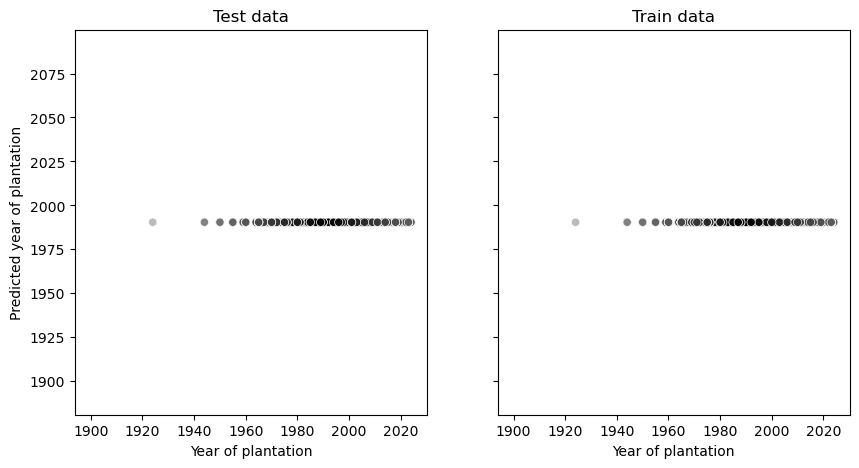

In [25]:
from sklearn.dummy import DummyRegressor

dummy_model=Pipeline([
    #('preprocessing', preprocessor_1),
    ('classifier',DummyRegressor(strategy='mean'))
])

dummy_model.fit(X_train,y_train)
show_results(dummy_model)

# Model 1

In [26]:
from sklearn.ensemble import RandomForestRegressor

model_1=Pipeline([
    ('preprocessing', preprocessor_1),
    ('classifier', RandomForestRegressor(max_depth=5, n_estimators=10,n_jobs=-1, random_state=random_state))
])
model_1.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Model 2

In [27]:
model_2=Pipeline([
    ('preprocessing', preprocessor_2),
    ('classifier', RandomForestRegressor(n_estimators=10, max_depth=5, n_jobs=-1, random_state=random_state))
])

model_2.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Model 3

In [28]:
from sklearn.linear_model import ElasticNet

model_3=Pipeline([
    ('preprocessing', preprocessor_2),
    ('classifier', ElasticNet(alpha=1,random_state=random_state))
])

model_3.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Model 4 ridge

In [29]:
from sklearn.linear_model import Ridge

model_4=Pipeline([
    ('preprocessing', preprocessor_2),
    ('classifier', Ridge(alpha=1,random_state=random_state))
])

model_4.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Model 5 Linear regression

In [30]:
from sklearn.linear_model import LinearRegression

model_5=Pipeline([
    ('preprocessing', preprocessor_2),
    ('classifier', LinearRegression(n_jobs=-1))
])

model_5.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# All results

-------- Dummy model --------
The RMSE is:
Test	18.3 years
Train	18.1 years


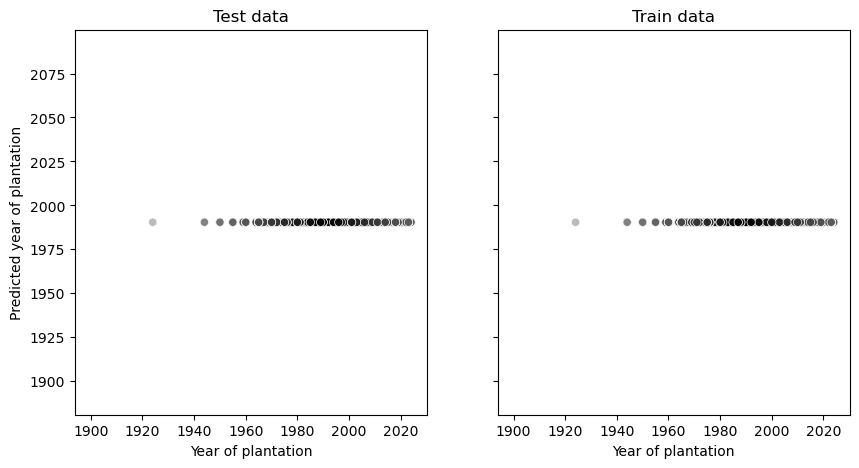

-------- Model 1: Genre + Species, randomForest --------
The RMSE is:
Test	11.6 years
Train	11.5 years


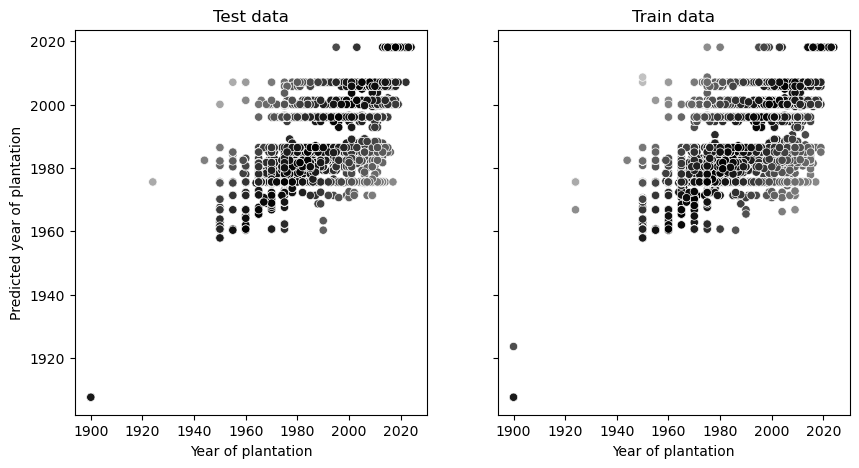

-------- Model 2: Genre, random Forest --------
The RMSE is:
Test	11.6 years
Train	11.6 years


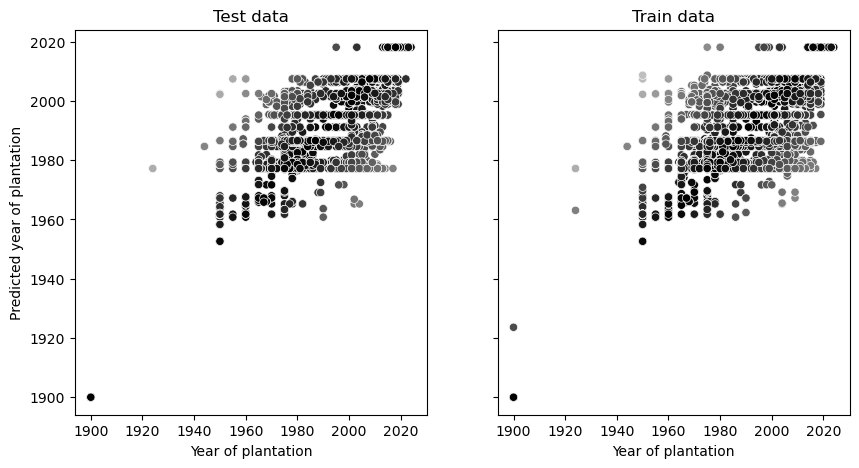

-------- Model 3: Genre, ElasticNet --------
The RMSE is:
Test	16.0 years
Train	15.9 years


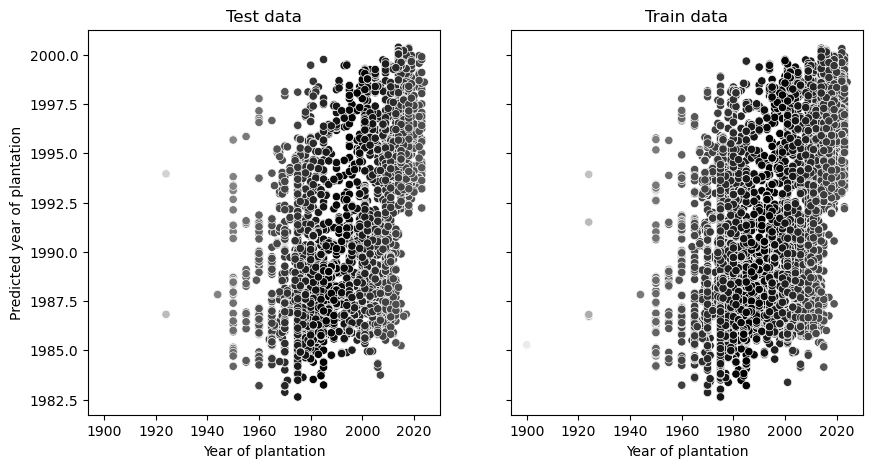

-------- Model 4: Genre, Ridge --------
The RMSE is:
Test	7.5 years
Train	7.1 years


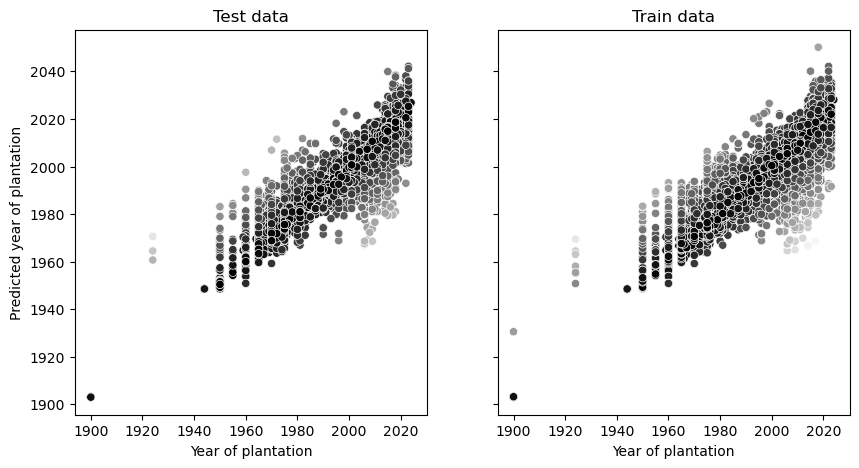

-------- Model 5: Genre, Linear regression --------
The RMSE is:
Test	7.5 years
Train	7.1 years


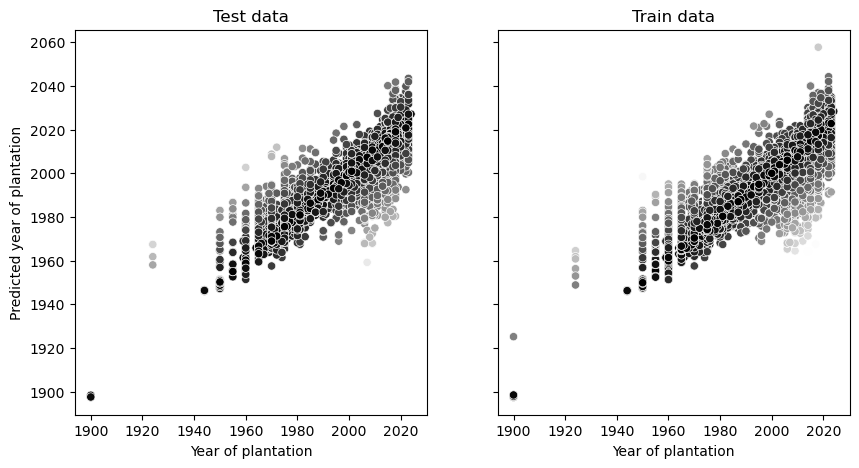

In [31]:
def print_title_model(name):
    number_dash=8
    print("-"*number_dash+" "+name+" "+"-"*number_dash)

print_title_model("Dummy model")
show_results(dummy_model)
print_title_model("Model 1: Genre + Species, randomForest")
show_results(model_1)
print_title_model("Model 2: Genre, random Forest")
show_results(model_2)
print_title_model("Model 3: Genre, ElasticNet")
show_results(model_3)
print_title_model("Model 4: Genre, Ridge")
show_results(model_4)
print_title_model("Model 5: Genre, Linear regression")
show_results(model_5)

I was using the two columns genre and species. I removed the species column. Performance are less important but I have a overfitting problem with the random forest

# Export and import a model

## Save the pipeline and model

In [32]:
# import joblib

# joblib.dump(grid_search.best_estimator_, "best_model.pkl")

## Import the pipeline and model

In [33]:
# model = joblib.load("best_model.pkl")